In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")

In [154]:
# Functions

def PSI(P, q):
    return q[0]*P**2 + q[1]*P**4 + q[2]*P**6

def dPSI_da_1(P):
    return P**2

def dPSI_da_11(P):
    return P**4

def dPSI_da_111(P):
    return P**6

def y(q):
    # analytical solution to PSI
    return (q[0]/3)*0.8**3 + (q[1]/5)*0.8**5 + (q[2]/7)*0.8**7

### (a)
Plot The energy for P on interval [-0.8, 0.8]

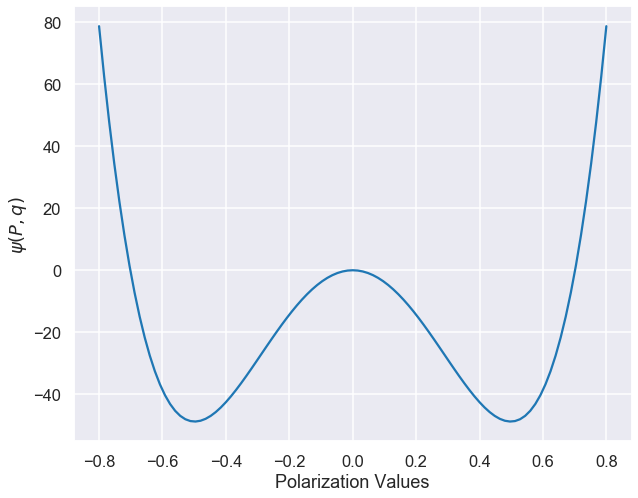

In [41]:
a_1, a_11, a_111 = -389.4, 761.3, 61.5
q = [a_1, a_11, a_111]
p_interval = np.linspace(-0.8, 0.8, 101)

fig, axe = plt.subplots(ncols=1, nrows=1, figsize=(10,8))
axe=sns.lineplot(p_interval, PSI(p_interval, q))
axe.set_xlabel('Polarization Values');
axe.set_ylabel('$\psi(P,q)$');


### (b) 
Compute Sensitivity Matrix $\chi$ using 17 equally spaced polarization values in the domain [0, 0.8]. Compute the rank of V and discuss the identifiability of the parameters

In [157]:
p_domain = np.linspace(0, 0.8, 17)
Chi = np.array([dPSI_da_1(p_domain), dPSI_da_11(p_domain), dPSI_da_111(p_domain)])

rank = np.linalg.matrix_rank(np.transpose(Chi)@Chi)
a = q[2]*0.8
b = q[2]*1.20

r = 50
delta = 1 /20

print(rank)
print(q[2]*0.8, q[2]*1.20)
print(a + (b-a)*np.random.uniform(0,1))

print('evaluate at q: ',y(q))

3
49.2 73.8
53.40632068847752
evaluate at q:  -14.722545371428575
